In [30]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import KFold
from mne.decoding import ReceptiveField

In [12]:
strffeat = loadmat('/userdata/jgauthier/ilina_timit/speech_analysis/out_sentence_details_timit_all_loudness.mat', simplify_cells=True)["sentdet"]

In [55]:
sorted(strffeat[0].keys())

['F13P',
 'F1Trans',
 'F23P',
 'F2Trans',
 'aud',
 'befaft',
 'biphn',
 'biphnNorm',
 'biphnNormbwmat',
 'biphnNormfwmat',
 'biphnbwmat',
 'biphnfwmat',
 'biphnlist',
 'dataf',
 'duration',
 'formants',
 'frmMedOns',
 'frmMedVal',
 'loudness',
 'loudnessCycleDur',
 'loudnessCycleId',
 'loudnessExtLoc',
 'loudnessExtVal',
 'loudnessRelExtLoc',
 'loudnessSentIdlong',
 'loudnessSentOns',
 'loudnessall',
 'loudnessallNames',
 'loudnesscyclePeakPhn',
 'name',
 'onsOff',
 'pause',
 'phnRed',
 'phnRedOnset',
 'phnfeat',
 'phnfeatonset',
 'phnmat',
 'phnmatonset',
 'phnnames',
 'phnnamesRed',
 'sentId',
 'sentence_onset',
 'sound',
 'soundOns',
 'soundf',
 'stress',
 'sylOns',
 'syllableNumber',
 'syltype',
 'vowel',
 'vowelId',
 'vowelStress',
 'vowelTimes',
 'wordL',
 'wordList',
 'wordOns']

In [50]:
out = loadmat('/userdata/ilinabg/data/EC159/timit/block_z/EC159_B18_HilbAA_70to150_8band_all_0_mel_TIMIT_zflag_global_out_resp_log.mat', simplify_cells=True)["out"]

In [52]:
out[0].keys()

dict_keys(['name', 'sound', 'soundf', 'dataf', 'aud', 'duration', 'Trials', 'befaft', 'resp'])

In [59]:
def add_details_to_out(out, sentdetV, infopath, corpus, cs):
    frmVows = set();  allFrm = []; vowId=None; subjFrm=None;
    if corpus != "timit":
        raise NotImplementedError("Only timit is supported")

    # load phoneme features and loudness (from liberty)
    if sentdetV == "v4":
        strffeat = loadmat(Path(infopath, 'out_sentence_details_timit_all_loudness.mat'),
                           simplify_cells=True)['sentdet']
    else:
        raise NotImplementedError("Only v4 is supported")
    
    strffeat_names = [strffeat[i]["name"] for i in range(len(strffeat))]
    addfields = set(strffeat[0].keys()) - set(out[0].keys())

    # allFrm = [strffeat.frmMedVal];

    for i, trial in enumerate(out):
        name_i = trial["name"]
        print(name_i)
        cl = strffeat_names.index(name_i)
        for field in addfields:
            trial[field] = strffeat[cl][field]
        
        # adding f0 to out struct, should be added to loudness all
        # before adddetails_to_out
        soundir='neural_preprocessing/';
        pitch_file = Path(infopath).parent / soundir / "TimitSounds" / f"{name_i}_pitch_int.txt"

        # Drop first and last rows
        pitch_df = pd.read_csv(pitch_file, sep='\t', header=None, na_values=["--undefined--"]) \
            .iloc[1:-1][3].fillna(0.)
        # Pad with zeros by referencing stress data
        before_pad = int(np.floor((len(trial["stress"]) - len(pitch_df)) / 2))
        after_pad = int(np.ceil((len(trial["stress"]) - len(pitch_df)) / 2))
        trial["f0"] = np.pad(pitch_df, (before_pad, after_pad))[None, :]

        # aggregate all scaleflagheard formant values
        if subjFrm is None:
            subjFrm = trial["frmMedVal"][:2, :]
        else:
            subjFrm = np.hstack((subjFrm, trial["frmMedVal"][:2, :]))

        # aggregate all vowel types for current corpus
        frmVows |= set(trial["vowel"])

        # aggregate all vowel ids
        if vowId is None:
            vowId = trial["vowelId"]
        else:
            vowId = np.hstack((vowId, trial["vowelId"]))

        trial["onset"] = trial["onsOff"][0]
        trial["offset"] = trial["onsOff"][1]

        trial["phnfeatConsOnset"] = trial["phnfeatonset"][[0, 1, 2, 7, 8, 10]]
        
        trial["maxDtL"] = trial["loudnessall"][5]

        # auditory and spectral features
        trial["aud"] = trial["aud"][:80]
        trial["F0"] = trial["f0"][0]
        trial["formantMedOnset"] = trial["frmMedOns"][:4]

        # add derivatives of existing fields - {'frmMedOnsbin'}
        # TODO you don't use this right?
        # out = makeBinnedFormantFeature(i, out, 'v1')


    # TODO pitch/formant logic is duplicated below -- why? maybe I got the block structure wrong in the code
    # if corpus in ["timit", "dimex"]:
    #     # all corpus formants (together for f2dmap_v3)
    #     # TODO why the reference to dimex?
    #     allcorpFrm = np.hstack((allcorpFrm, trial["frmMedVal"]))
        
        # Dvow=loadDD(corpus, allFrm);
        
        # % all added features
        # for i = 1:length(out)
                        
        #     % using midpoint (using all sentences)
        #     % out = makeFormantMapFeature(i, out, allFrm, vowId, corpus, 'allsent');
        #     % using midpoint (using subject specific sentences)
        #     % out = makeFormantMapFeature(i, out, subjFrm, vowId, corpus, 'subjsent', cs);
            
        #     %%  optional if model is used
        # %     make all of the other strf features
        #     % relative formant median onset binned 
        # %     out = makeBinnedFormantFeature(i, out, 'v6');
        # % %   relative continuous formant binned
        # %     out = makeBinnedFormantFeature(i, out, 'v8');    
        # % %   log scaled binned continuous formant 
        # %     out = makeBinnedFormantFeature(i, out, 'v9');
        # %     out = makeBinnedFormantFeature(i, out, 'v11');
        # %     out = makeBinnedFormantFeature(i, out, 'v12');
        # %     out = makeBinnedFormantFeature(i, out, 'v13');
        # %     out = makeBinnedFormantFeature(i, out, 'v14');
        # %     out = makeBinnedFormantFeature(i, out, 'v15');
        # %     out = makeBinnedFormantFeature(i, out, 'v16');
        # %     out = makeVowelTypeFeature(i, out, frmVows);
        # % 
        # %     without midpoint (using same map for both corpus, 10 by 10)
        # %     out = makeFormantMapFeature_v3(i, out, vowId, allcorpFrm);
            
        # %     without midpoint (using all sentences)
        # %     out = makeFormantMapFeature_v2(i, out, allFrm(1:2, :), vowId, corpus, 'allsent');
            
        # %     without midpoint (using all sentences, but subject specific sentences)
        # %     out = makeFormantMapFeature_v2(i, out, subjFrm, vowId, corpus, 'subjsent', cs);
        # %     
        # %     formant interaction effects
        # %     out = makeFormantValEffect(i, out, 'v1', allFrm(1:2, :), vowId);
        # %     out = makeFormantValEffect(i, out, 'v2', allFrm(1:2, :), vowId);
            
        #     %% non-optional
        #     % add pitch to out struct
        #     out = makeF0(i, out, Dvow); 
            
        #     % normalized formant values
        #     out = makeNormFormantVals(i, out, Dvow);
            
        #     % add median offset to the out struct
        #     out = makeMedianFormantOffset(i, out);
            
        #     % add vowelType
        #     out = makeVowelCategory(i, out);    
    
    # # add relative binned pitch (not doing this per sentence, because normalize
    # # over entire sentence)
    # numBins = 10;
    # out = makeBinnedPitchFeat(out, numBins);
    
    # # add relative loudness features
    # numBins = 10;
    # out = makeRelLoudness(out, numBins, 'maxDtL');
    
    # # add surprisal features
    # numBins = 8;
    # out = makeSurprisal(out, numBins, corpus);
    # if strcmp(corpus, 'timit')
    #     out = makeSurprisal(out, numBins, [corpus '_cross']);
    # end
    
    # plot formant variance map
    # out = strf_plotFormantVariance(out);

    return out


In [72]:
def strf(out, modelfields, cs, binaryModelFields,
         sentdet, respField, strfSaveFolder, scaleflag,
         nFoldsRun, foldInd, STRFEl=None, pitchSel=None):
    # binaryModelFields turns all predictors in model into binary 1/0 
    saveSmallFlag = 1;

    respField = respField or 'resp'
    strfSaveFolder = strfSaveFolder or Path("out_strf", cs)

    if not isinstance(scaleflag, np.ndarray) or scaleflag.ndim == 0:
        scaleflag = scaleflag * np.ones(len(modelfields))

    if STRFEl is None:
        if cs in ['EC53', 'EC85', 'EC89', 'EC143']:
            STRFEl = range(1, 289)
        elif cs in ['EC212']:
            STRFEl = range(1, 385)
        elif cs in ['EC75', 'EC124', 'EC200']:
            STRFEl = range(1, 65)
        elif cs in ['EC177', 'EC161']:
            STRFEl = range(1, 129)
        elif cs in ['EC193']:
            STRFEl = range(1, 275)
        else:
            STRFEl = range(1, 257)
    
    if pitchSel is not None:
        raise NotImplementedError("pitchSel not implemented")
    
    # estimation parameters
    inclSentOns = np.ones(len(modelfields))
    zscoreXflag = np.ones(len(modelfields))
    zscoreYflag = np.zeros(len(modelfields))
    scaleXflag = np.ones(len(modelfields))
    scaleYflag = np.zeros(len(modelfields))
    highpassflag = np.zeros(len(modelfields))
    modelnames = [f"{modelfields[i]}_zX{zscoreXflag[i]}_zY{zscoreYflag[i]}_scX{scaleXflag[i]}_scY{scaleYflag[i]}_hp{highpassflag[i]}_SentOns{inclSentOns[i]}_sentScale{scaleflag[i]}"
                  for i in range(len(modelfields))]
    
    # STRF setup - do not change these parameters
    time_lag = 0.6
    regalphas = np.logspace(0, 7, 20)

    # paper strfs
    nfold = 5;
    fullmodel_flag = 0;
    bootflag = 1;
    nboots = 10;
    edgeflag = 1;
    dataf = out[0]["dataf"];
    fs = out[0]["soundf"]
    # assert dataf == fs, f"Neural and sound sampling rate must match ({dataf} Hz != {fs} Hz)"

    feature_lookups = modelfields.split("_")
    X, Y, feature_names, feature_shapes = [], [], None, None
    for i, trial in enumerate(out):
        # TODO what to do about repeats?
        Yi = trial[respField]
        if Yi.ndim == 3:
            continue
    
        Xi = []
        feature_names_i, feature_shape_i = [], []
        for feature_lookup in feature_lookups:
            feature = trial[feature_lookup]
            if feature.ndim == 2:
                for j, feature_row in enumerate(feature):
                    Xi.append(feature_row)

                    feature_names_i.append(f"{feature_lookup}_{j}")
                feature_shape_i.append(feature.shape[0])
            else:
                Xi.append(feature)
                feature_names_i.append(feature_lookup)
                feature_shape_i.append(1)

        # print(list(zip([xi.shape for xi in Xi], feature_names_i)))
        Xi = np.stack(Xi).astype(float).T
        X.append(Xi)
        Y.append(Yi)

        if feature_names is None:
            feature_names = feature_names_i
            feature_shapes = feature_shape_i
        else:
            assert feature_names == feature_names_i
            assert feature_shapes == feature_shape_i

    # TODO boundaries
    # TODO remove zero-padding on trials
    X = np.concatenate(X)
    Y = np.concatenate(Y, axis=1).T
    
    X -= X.mean(axis=0)
    X /= (X.max(axis=0) - X.min(axis=0))

    # Subset instructed electrodes
    if STRFEl is not None:
        Y = Y[:, STRFEl]
    # Normalize response
    Y -= Y.mean(axis=0)
    Y /= (Y.max(axis=0) - Y.min(axis=0))

    # DEV
    # X = X[:1000]
    # Y = Y[:1000]

    model = ReceptiveField(tmin=0, tmax=time_lag, sfreq=dataf, feature_names=feature_names)
    model.fit(X, Y)

    return model



In [73]:
ridgeflag =1;
strfFlag = 1;
allrFlag = 0;

sSIDs={'EC172', 'EC163', 'EC105', 'EC100', 'EC203', 'EC214', 'EC225', 'EC252', 'EC152', 'EC116'};  
eSIDs={'EC196', 'EC195', 'EC183', 'EC212', 'EC186', 'EC219', 'EC221', 'EC222', 'EC235', 'EC242'};
bSIDs={'EC122', 'EC129', 'EC139', 'EC159', 'EC161', 'EC202', 'EC200', 'EC266', 'EC260'}; 
mSIDs={'HS8', 'HS9', 'HS10',  'HS11'}; # for asccd
taskSIDs = {'EC237', 'EC214', 'EC219', 'EC222'}; # 'EC221', 'EC225', 'EC235', ...
   # 'EC242', 'EC243'

# for stress task / VTE
stressSIDs = {'EC219','EC221','EC222','EC228','EC235', 'EC242', 'EC243', 'EC250', 'EC278', 'EC290'};
vteSIDs = {'EC183', 'EC186', 'EC195', 'EC208'};
idkSIDs = {'EC197', 'EC237', 'EC261'}; # ??

# allsid = taskSIDs;
# ec203, 202, 214 were all added after March 18, 2020 lab meeting
allsid = mSIDs; # [eSIDs bSIDs sSIDs mSIDs];

# DEV jon
allsid = ['EC152']

modelfields=['onset_phnfeatConsOnset_maxDtL_formantMedOnset_F0_aud']

# - - - - setup
sentdetV = 'v4';
zFolder = 'block_z';
corpus ='timit';# 'asccd';

# greater than 170 (gt170, female), less than 170 (lt170, male)
pitchSel = None; # 'lte170', '', 'gt170', 'mini', 'gtxlte170', 'ltexgt170', bt135-238
# for the ~25, 75 prctile respectively
# 'lt135', 'gt238', 'bt135-238', 'bt135-200', 'bt200-236'

# TODO ??
binaryModelFields = np.zeros((1, len(modelfields)))

datapath = "/userdata/ilinabg/data/"
# datapath = "/userdata/jgauthier/ilina_timit/"
prcsdpath = "/data_store1/human/prcsd_data/"
outStrfFolder = Path(corpus) / zFolder / 'strf' / 'v5'
scaleflag = 0; # scale predictors within each sentence.
nFoldsRun = 1; # full cross-validation

# STRF model fitting
if strfFlag:
    print('%% --------------------- strf model fitting --------------------- %%');

    # model specifications. first column indicates subject ID; second column indicates model field
    runmods = np.zeros((len(allsid) * len(modelfields), 2), dtype=int)
    runmods[:, 0] = np.tile(np.arange(len(allsid)), len(modelfields))
    runmods[:, 1] = np.repeat(np.arange(len(modelfields)), len(allsid))

    for i, (subj_idx, field_idx) in enumerate(runmods):
        cs = allsid[subj_idx]
        curmod = modelfields[field_idx]

        corpus_path = Path(datapath) / cs / corpus / zFolder
        outfile = list(corpus_path.glob(f'*_*HilbAA_70to150_8band*out_resp_log.mat'))
        if len(outfile) == 0:
            raise ValueError(f'no out file for {corpus_path}/*out_resp_log.mat')
        
        cout = loadmat(outfile[0], simplify_cells=True)
        out = cout['out']
       
        # add sentence details to out
        # infopath = "/home/ilinabg/matlab/analysis/continuous_speech/speech_analysis"
        infopath = "/userdata/jgauthier/ilina_timit/speech_analysis/"
        out = add_details_to_out(out,sentdetV,infopath, corpus, cs);

        if corpus == "timit":
            repSentName = ['fcaj0_si1479','fcaj0_si1804','fdfb0_si1948','fdxw0_si2141',
                'fisb0_si2209','mbbr0_si2315','mdlc2_si2244','mdls0_si998','mjdh0_si1984','mjmm0_si625']
        else:
            raise NotImplementedError("Only timit is supported")
        
        repSentLoc = np.isin([item["name"] for item in out], repSentName)

        # TODO incorporate repSent logic
        cv = KFold(n_splits=5, shuffle=True)
        curbinModF = binaryModelFields[field_idx]
        result = strf(out=out, modelfields=curmod, cs=cs, binaryModelFields=curbinModF,
            sentdet=sentdetV, respField=[], strfSaveFolder=None, scaleflag=scaleflag,
            nFoldsRun=nFoldsRun, foldInd=None,
            STRFEl=list(range(7)),  # list(range(out[0]["resp"].shape[0])),
            pitchSel=pitchSel)
        
        break


%% --------------------- strf model fitting --------------------- %%
fawf0_si1000
fbcg1_si2242
fcaj0_si1479
fcaj0_si1804
fcjs0_si2237
fcke0_si1111
fclt0_si2068
fcmm0_si1083
fcmm0_si453
fdfb0_si1948
fdfb0_si2010
fdml0_si1779
fdnc0_si2287
fdxw0_si2141
feeh0_si471
feme0_si2135
fgdp0_si1618
fisb0_si2209
fjcs0_si1833
fjre0_si1116
fjsp0_si804
fkde0_si2221
flac0_si901
flag0_si2094
flbw0_si2253
fleh0_si1681
flhd0_si1827
fljg0_si2241
flkd0_si1369
flma0_si1243
fmah1_si2139
fmcm0_si1810
fnkl0_si1522
fpas0_si944
frew0_si1910
frjb0_si1794
fsah0_si1874
fskc0_si786
ftaj0_si474
ftmg0_si2162
majp0_si1074
marw0_si1906
mbar0_si1949
mbbr0_si2315
mbcg0_si486
mbdg0_si833
mbef0_si1911
mbma1_si2207
mbom0_si1644
mbsb0_si1983
mcal0_si1768
mcdd0_si1513
mcem0_si1398
mcre0_si1725
mdks0_si1066
mdlc2_si2244
mdlh0_si574
mdlm0_si1864
mdls0_si998
mdmt0_si1832
mdsj0_si2092
mewm0_si1978
mfxs0_si1674
mfxv0_si1635
mgaf0_si652
mgak0_si2296
mgar0_si1694
mgrl0_si1497
mjac0_si2148
mjar0_si1988
mjbr0_si1001
mjbr0_si2261
mjde0_s

  0%|          | Sample : 0/4464 [00:00<?,       ?it/s]

In [34]:
from src.analysis.trf import trf_to_df

In [74]:
result.coef_.shape

(256, 93, 61)

In [75]:
trf_df = trf_to_df(result, list(range(result.coef_.shape[0])))
trf_df

,feature,output_name,input_dim,output_dim,lag,time,coef
0,onset,0,0,0,0,0.00,-0.007047
1,onset,0,0,0,1,0.01,0.000323
2,onset,0,0,0,2,0.02,0.006065
3,onset,0,0,0,3,0.03,0.005858
4,onset,0,0,0,4,0.04,0.001871
...,...,...,...,...,...,...,...
1452283,aud_79,255,92,255,56,0.56,0.017438
1452284,aud_79,255,92,255,57,0.57,0.018088
1452285,aud_79,255,92,255,58,0.58,0.016015
1452286,aud_79,255,92,255,59,0.59,0.017514


In [78]:
trf_df.feature.unique()

array(['onset', 'phnfeatConsOnset_0', 'phnfeatConsOnset_1',
       'phnfeatConsOnset_2', 'phnfeatConsOnset_3', 'phnfeatConsOnset_4',
       'phnfeatConsOnset_5', 'maxDtL', 'formantMedOnset_0',
       'formantMedOnset_1', 'formantMedOnset_2', 'formantMedOnset_3',
       'F0', 'aud_0', 'aud_1', 'aud_2', 'aud_3', 'aud_4', 'aud_5',
       'aud_6', 'aud_7', 'aud_8', 'aud_9', 'aud_10', 'aud_11', 'aud_12',
       'aud_13', 'aud_14', 'aud_15', 'aud_16', 'aud_17', 'aud_18',
       'aud_19', 'aud_20', 'aud_21', 'aud_22', 'aud_23', 'aud_24',
       'aud_25', 'aud_26', 'aud_27', 'aud_28', 'aud_29', 'aud_30',
       'aud_31', 'aud_32', 'aud_33', 'aud_34', 'aud_35', 'aud_36',
       'aud_37', 'aud_38', 'aud_39', 'aud_40', 'aud_41', 'aud_42',
       'aud_43', 'aud_44', 'aud_45', 'aud_46', 'aud_47', 'aud_48',
       'aud_49', 'aud_50', 'aud_51', 'aud_52', 'aud_53', 'aud_54',
       'aud_55', 'aud_56', 'aud_57', 'aud_58', 'aud_59', 'aud_60',
       'aud_61', 'aud_62', 'aud_63', 'aud_64', 'aud_65', 'aud

<Axes: xlabel='time', ylabel='coef'>

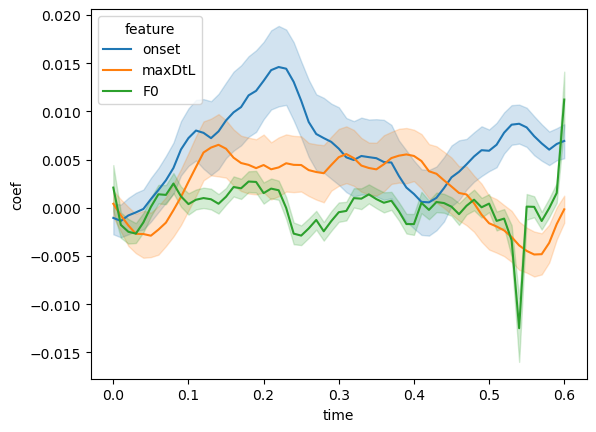

In [79]:
sns.lineplot(data=trf_df[trf_df.feature.isin(("onset", "F0", "maxDtL"))],
             x='time', y='coef', hue='feature')